In [36]:
import pandas as pd 
import numpy as np 
import pathlib as path
import matplotlib.pyplot as plt
import random
from PIL import Image
from random import sample

In [37]:
#define the relevant path to the current batch you wish to parse
gap_name='pilot_same_day' #dont change this as this parsing sciprt only handles the same day batches.  

project_name='birds'
experiment_name='experiment 1'
batch_name='batch 1'
qualification_method='strict'

PATH_TO_BATCH=path.Path.cwd().parent.parent.parent / 'projects' / project_name / experiment_name / 'collected data' / gap_name / batch_name
PATH_TO_BATCH_DATA = PATH_TO_BATCH / 'data'

if PATH_TO_BATCH.exists():
    print('batch folder found at:\n' ,PATH_TO_BATCH)
else: 
    print('path to batch is non existent:\n',PATH_TO_BATCH)

batch folder found at:
 c:\Users\d_abe\Desktop\human similarity database\edens github repo\visual-memory-project\projects\birds\experiment 1\collected data\pilot_same_day\batch 1


In [38]:
def set_criterions(type='strict'):
    #the function sets the criterions and returns them as a pd.series
    criterions_df=pd.Series(dtype=float)

    #update the non changing ciretrions: 
    criterions_df['demo_arrow_correctness']=1
    criterions_df['encoding_arrow_accuracy']=0.6
    criterions_df['longest_allowed_consequtive_strike']=15
    criterions_df['fast_threshold']=0.3

    if type=='strict':
        criterions_df['demo_accuracy_treshold']=0.5 
        
        criterions_df['fast_allowed_count']=3 
        criterions_df['slow_threshold']=10
        criterions_df['slow_allowed_count']=2
        criterions_df['binom_single_layer']=0.75
        criterions_df['binom_averages']=0.61
    elif type=='loose': #here we change things to be easier to pass
        criterions_df['demo_accuracy_treshold']=0
        criterions_df['fast_threshold']=0.3
        criterions_df['fast_allowed_count']=5 
        criterions_df['slow_threshold']=15
        criterions_df['slow_allowed_count']=5
        criterions_df['binom_single_layer']=0.55
        criterions_df['binom_averages']=0.55
    else: 
        raise Exception('requested method is not defined')
    
    return criterions_df


In [39]:

criterions_df=set_criterions(qualification_method)
criterions_df

demo_arrow_correctness                 1.00
encoding_arrow_accuracy                0.60
longest_allowed_consequtive_strike    15.00
fast_threshold                         0.30
demo_accuracy_treshold                 0.50
fast_allowed_count                     3.00
slow_threshold                        10.00
slow_allowed_count                     2.00
binom_single_layer                     0.75
binom_averages                         0.61
dtype: float64

In [40]:
AMAZON_WORKER_fILE_PATH= PATH_TO_BATCH / path.Path(batch_name.capitalize().replace(' ','_')+'_batch_results.csv')

batch_workers_df=pd.read_csv(AMAZON_WORKER_fILE_PATH)
print('number of amazon workers as reported from the amazon workers file : ',len(batch_workers_df))

#check how many participants are in the downloaded folder: 
participants_list_csvs=[file.name for file in PATH_TO_BATCH_DATA.iterdir() if '.csv' in file.name and file.stat().st_size>10000]
participants_list_names=[file.split('_')[0] for file in participants_list_csvs]
print(f'number of participant files (of sufficient size) in the downloaded results batch: {len(participants_list_csvs)}')
print(f'number of unique participant names in the batch: {len(set(participants_list_names))}')
#solve the non unique participants:
non_unique_names=np.unique([name for name in participants_list_names if participants_list_names.count(name)>1])

if len(non_unique_names)>0:
   print(f'\nhandling duplicate participants {len(non_unique_names)}:')
   #find the most recent/biggest file size from each non unique participant: 
   for participant in non_unique_names:
      all_curr_participant_csv_names=list(np.array(participants_list_csvs)[np.where(np.array(participants_list_names)==participant)])
      #get the system info on each of these duplicate files: 
      filesizes=[(PATH_TO_BATCH / file).stat().st_size for file in all_curr_participant_csv_names]
      filedates=[(PATH_TO_BATCH / file).stat().st_ctime for file in all_curr_participant_csv_names]
      largest_filesize_ind=np.argmax(filesizes) #get the index of the largest file from the duplicates
      latest_filedate_ind=np.argmax(filedates)  #get the index of the latest file from the duplicates
      if largest_filesize_ind==latest_filedate_ind: #if the same size is the most recent and largest use it as the participant file: 
         print(f'{participant} has {len(all_curr_participant_csv_names)} duplicate files  - taking the largest and latest file for this participant')
         valid_csv=all_curr_participant_csv_names[largest_filesize_ind]
         #remove it from the current subject duplicates list: 
         all_curr_participant_csv_names.remove(valid_csv)
         #remove the other duplicates fromt he participanst_list_csv: 
         for csv_to_remove in all_curr_participant_csv_names:
            participants_list_csvs.remove(csv_to_remove)
      else:
         print(f'{participant} has {len(all_curr_participant_csv_names)} duplicate files  the largest file is not the latest, so need to resolve this conflict manualy')

#get the aligned names vector after removing the duplicates: 
participants_list_names=[file.split('_')[0] for file in participants_list_csvs]
print(f'\nafter removing duplicate files, number of valid participant files = {len(participants_list_names)}\n')


#make sure the participants reported in the amazon workers corresponds to the valid csv files we got: 
print('going over the workers list as reported in amazon and finding a valid csv file for each')
valid_participants_files=[]
valid_participants_names=[]
for cur_participant in batch_workers_df['WorkerId'].values:
    if cur_participant in participants_list_names: 
      #update the batch workers file with the relevant csv name and validation columns
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'csv_path']=participants_list_csvs[participants_list_names.index(cur_participant)]
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'Approve']='x'
      #print(cur_participant)'
      valid_participants_files.append(participants_list_csvs[participants_list_names.index(cur_participant)]) 
      valid_participants_names.append(cur_participant)
    else:
      print('invalid',cur_participant)
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'Reject']='no results file was found on pavlovia servers'
    
print(f'number of valid participants to go to further processing is: {len(valid_participants_files)}')     
    

number of amazon workers as reported from the amazon workers file :  30
number of participant files (of sufficient size) in the downloaded results batch: 30
number of unique participant names in the batch: 30

after removing duplicate files, number of valid participant files = 30

going over the workers list as reported in amazon and finding a valid csv file for each
invalid A1M9D6GLMMA4OA
invalid AT80V0Q1U2LCI
invalid AAOYROFYRP1UM
number of valid participants to go to further processing is: 27


In [41]:
batch_workers_df[['WorkerId','Approve','Reject','Answer.surveycode','csv_path']] #will add more columns with more information on disqualfication so we can decide if we pay or not

,WorkerId,Approve,Reject,Answer.surveycode,csv_path
0,A1M9D6GLMMA4OA,NaN,no results file was found on pavlovia servers,A1M9D6GLMMA4OA,NaN
1,A37R0JYAB3QEX9,x,NaN,mhpur,A37R0JYAB3QEX9_2022-12-27_14h31.50.128.csv
2,A3TBG0S2IEBVHU,x,NaN,mhpur,A3TBG0S2IEBVHU_2022-12-27_16h27.52.566.csv
3,A1BRJXBMTURQNT,x,NaN,mhpur,A1BRJXBMTURQNT_2022-12-27_14h53.25.694.csv
4,A50K26F2IS94U,x,NaN,mhpur,A50K26F2IS94U_2022-12-27_14h40.10.329.csv
5,A33YJIL8ZY6XSB,x,NaN,mhpur,A33YJIL8ZY6XSB_2022-12-27_14h32.28.293.csv
6,A306SRE7WZDAZS,x,NaN,mhpur,A306SRE7WZDAZS_2022-12-27_14h49.07.601.csv
7,A15UAR6NM0QVQN,x,NaN,mhpur,A15UAR6NM0QVQN_2022-12-27_15h31.31.180.csv
8,AIXO7JFFSBR5O,x,NaN,mhpur,AIXO7JFFSBR5O_2022-12-28_01h09.27.963.csv
9,A1C508BB6CF8VR,x,NaN,mhpur,A1C508BB6CF8VR_2022-12-27_15h34.46.494.csv


In [42]:
def find_largest_consequtive_repetition(responses_array):
#add a stop value so the loop will use the logic also if the end of the responses is all repeating: 
    responses_array=np.append(responses_array,[99])
    longest_rep_dict=dict()
    last_input=responses_array[0]
    consequtive_rep_counter=0
    for response in responses_array[1:]: 
        if response==last_input: #if consequtive rep: 
            consequtive_rep_counter=consequtive_rep_counter+1 #add to counter
        else: #once a new entry is in the vector - store the counter rep information 
            if last_input in longest_rep_dict.keys(): #if it was allready stored in our dictionary
                if longest_rep_dict[last_input]<consequtive_rep_counter: #replace the counter only if it is higher than what stored in dict
                    longest_rep_dict[last_input]=consequtive_rep_counter
            else: #this entry is not yet in the dictionary: add it 
                longest_rep_dict[last_input]=consequtive_rep_counter
            
            consequtive_rep_counter=0
            last_input=response
    return max(longest_rep_dict.values())

In [43]:
def process_worker_results(PATH_TO_BATCH_DATA,subject_name):
    cur_sub=pd.read_csv(PATH_TO_BATCH_DATA / subject_name)
    sub_demographics=cur_sub[['workID','Age','Gender']].iloc[0]

    #extract demo related information: 

    #if participant did not click on the arrow during the demo a 'demo_encoding_response.rt' colmumn wont exists: 
    #thus we will create one and fill it with nans (so everything will be consistent with other participants)
    if not('demo_encoding_response.rt' in cur_sub.columns):
        cur_sub['demo_encoding_response.rt']=np.nan
    demo_columns=['demo_encoding_loop.thisTrialN','DemoImage','DemoCorrect','demo_encoding_response.rt','demo_encoding_response.keys']

    sub_demo_information=cur_sub[demo_columns]
    empty_inds=sub_demo_information.loc[sub_demo_information.isnull().apply(lambda x: all(x), axis=1)].index
    #drop irrelevant columns: 
    sub_demo_information=sub_demo_information.drop(index=empty_inds)


    #extract the demo test columns: 
    demo_test_columns=['demo_test_response.keys','demo_test_response.corr','demo_test_response.rt','demo_test_loop.thisTrialN','DemoImage1','DemoImage2','DemoCorrectTest']
    sub_demo_test_information=cur_sub[demo_test_columns]
    empty_inds=sub_demo_test_information.loc[sub_demo_test_information.isnull().apply(lambda x: all(x), axis=1)].index
    #drop irrelevant columns: 
    sub_demo_test_information=sub_demo_test_information.drop(index=empty_inds)

    demo_df=pd.concat([sub_demo_information.reset_index(),sub_demo_test_information.reset_index()],axis=1)

    #extract real experiment related information: 

    #if participant did not click on the arrow during the encoding a 'test_encoding_response.rt' column wont exists: 
    #thus we will create one and fill it with nans (so everything will be consistent with other participants)
    if not('test_encoding_response.rt' in cur_sub.columns):
        cur_sub['test_encoding_response.rt']=np.nan


    encoding_related_columns=['test_encoding_response.keys','test_encoding_response.corr','trials.thisTrialN','target_image','pair','layer','correct','test_encoding_response.rt','key_resp_end.keys']
    sub_encoding_information=cur_sub[encoding_related_columns]
    #encoding section ends with a key press of the space key: so seperate this phase by finding this space key row
    end_of_section_ind=np.where(sub_encoding_information['key_resp_end.keys']=='space')[0][0]
    sub_encoding_information=sub_encoding_information.iloc[0:end_of_section_ind]
    #remove all the rows that precede the real encoding phase: 
    empty_inds=sub_encoding_information.loc[sub_encoding_information.isnull().apply(lambda x: all(x), axis=1)].index
    sub_encoding_information=sub_encoding_information.drop(index=empty_inds).reset_index()

    #extract real experiment TEST related information: 
    test_related_columns=['layer','correct','test_test_response.keys','test_test_response.corr','test_test_response.rt','trials_2.thisRepN','trials_2.thisTrialN','trials_2.thisN','trials_2.thisIndex','trials_2.ran','image1','image2']
    sub_test_information=cur_sub[test_related_columns].iloc[end_of_section_ind+2:-1]


    subject_dictionary=dict()
    subject_dictionary['demographics']=sub_demographics
    subject_dictionary['demo_df']=demo_df
    subject_dictionary['encoding_df']=sub_encoding_information
    subject_dictionary['test_df']=sub_test_information

    return subject_dictionary



In [44]:
all_subjects_demo_df=pd.DataFrame()
all_subjects_encoding_df=pd.DataFrame()
all_subjects_test_df=pd.DataFrame()
all_subjects_biographics_df=pd.DataFrame()

for subject_name in valid_participants_files:
    #print(subject_name)
    curr_subject_dictionary=process_worker_results(PATH_TO_BATCH_DATA,subject_name)
    curr_demo_df=curr_subject_dictionary['demo_df']
    #extract just the worker id as the subject name
    subject_name=subject_name.split('_')[0]
    curr_demo_df['subject']=subject_name
    curr_test_df=curr_subject_dictionary['test_df']
    curr_test_df['subject']=subject_name
    curr_encoding_df=curr_subject_dictionary['encoding_df']
    curr_encoding_df['subject']=subject_name
    curr_demographics_df=curr_subject_dictionary['demographics']
    curr_demographics_df['subject']=subject_name

    all_subjects_demo_df=pd.concat([all_subjects_demo_df,curr_demo_df],axis=0,ignore_index=True)
    all_subjects_encoding_df=pd.concat([all_subjects_encoding_df,curr_encoding_df],axis=0,ignore_index=True)
    all_subjects_test_df=pd.concat([all_subjects_test_df,curr_test_df],axis=0,ignore_index=True)
    all_subjects_biographics_df=pd.concat([all_subjects_biographics_df,pd.DataFrame(curr_demographics_df).T],axis=0,ignore_index=True)

all_subjects_demo_df.to_csv(PATH_TO_BATCH / 'all_subjects_demo_df.csv')
all_subjects_encoding_df.to_csv(PATH_TO_BATCH / 'all_subjects_encoding_df.csv')
all_subjects_test_df.to_csv(PATH_TO_BATCH / 'all_subjects_test_df.csv')
all_subjects_biographics_df.to_csv(PATH_TO_BATCH / 'all_subjects_biographics_df.csv')

In [45]:
from unicodedata import category

# if there are any empty values - fill with mean of subjects age 
mean_value = all_subjects_biographics_df['Age'].mean()
all_subjects_biographics_df['Age'].fillna(value=mean_value, inplace=True)
all_subjects_biographics_df['Age'] = all_subjects_biographics_df['Age'].astype(np.int64)

all_subjects_biographics_df['Age']=all_subjects_biographics_df['Age'].astype(int)
all_subjects_biographics_df['Gender'].replace({'woman':'female','FEMLAE':'female','Male':'male','MALE':'male','FEMALE':'female','Female':'female','ale':'male'},inplace=True)
if len(set(all_subjects_biographics_df['Gender'].values))<=2:
    print('transformed the gender column to be consistent having two possible values:',np.unique(all_subjects_biographics_df['Gender'].values))
else: 
    print('gender is still inconsistent with more than 2 unique values:',set(all_subjects_biographics_df['Gender'].values))
all_subjects_biographics_df['Gender']=all_subjects_biographics_df['Gender'].astype("category")

mean_age,min_age,max_age=all_subjects_biographics_df['Age'].mean(),all_subjects_biographics_df['Age'].min(),all_subjects_biographics_df['Age'].max()
female_prop=all_subjects_biographics_df.loc[all_subjects_biographics_df['Gender']=='female','Gender'].count()/all_subjects_biographics_df['Gender'].count()

print(f'Mean age: {mean_age:.2f}, range: [{min_age} - {max_age}], {female_prop:.2f}% female')


gender is still inconsistent with more than 2 unique values: {'Genderqueer', 'male', 'female', 'Man'}
Mean age: 36.81, range: [25 - 62], 0.30% female


# this part plots the seperate dataframes: 
### demo phase (encoding and test in the same dataframe)
### encoding experiment phase
### test experiment phase

In [46]:
all_subjects_demo_df.head(5)

,index,demo_encoding_loop.thisTrialN,DemoImage,DemoCorrect,demo_encoding_response.rt,demo_encoding_response.keys,index,demo_test_response.keys,demo_test_response.corr,demo_test_response.rt,demo_test_loop.thisTrialN,DemoImage1,DemoImage2,DemoCorrectTest,subject
0,4,0.0,flower1.jpg,NaN,NaN,NaN,12.0,right,0.0,3.8023,0.0,flower1.jpg,flower1_pair.jpg,left,A37R0JYAB3QEX9
1,5,1.0,flower2.jpg,NaN,NaN,NaN,13.0,right,1.0,3.1057,1.0,flower2_pair.jpg,flower2.jpg,right,A37R0JYAB3QEX9
2,6,2.0,left.jpg,left,0.5246,left,14.0,left,1.0,2.2862,2.0,flower3.jpg,flower3_pair.jpg,left,A37R0JYAB3QEX9
3,7,3.0,flower3.jpg,NaN,NaN,NaN,15.0,left,1.0,1.5658,3.0,flower4.jpg,flower4_pair.jpg,left,A37R0JYAB3QEX9
4,8,4.0,flower4.jpg,NaN,NaN,NaN,16.0,left,0.0,3.8350,4.0,flower5_pair.jpg,flower5.jpg,right,A37R0JYAB3QEX9


In [47]:
all_subjects_encoding_df.head(5)

,index,test_encoding_response.keys,test_encoding_response.corr,trials.thisTrialN,target_image,pair,layer,correct,test_encoding_response.rt,key_resp_end.keys,subject
0,20,NaN,1.0,0.0,DOUBLE_BRESTED_CORMARANT_5.jpg,CHINESE_POND_HERON_2.jpg,3.0,NaN,NaN,NaN,A37R0JYAB3QEX9
1,21,NaN,1.0,1.0,OCELLATED_TURKEY_1.jpg,AMERICAN_PIPIT_1.jpg,2.0,NaN,NaN,NaN,A37R0JYAB3QEX9
2,22,NaN,1.0,2.0,CHUKAR_PARTRIDGE_5.jpg,OSTRICH_5.jpg,1.0,NaN,NaN,NaN,A37R0JYAB3QEX9
3,23,NaN,1.0,3.0,IVORY_GULL_1.jpg,FAIRY_TERN_4.jpg,3.0,NaN,NaN,NaN,A37R0JYAB3QEX9
4,24,NaN,1.0,4.0,BREWERS_BLACKBIRD_3.jpg,CAPE_LONGCLAW_2.jpg,3.0,NaN,NaN,NaN,A37R0JYAB3QEX9


In [48]:
all_subjects_test_df.head(5)

,layer,correct,test_test_response.keys,test_test_response.corr,test_test_response.rt,trials_2.thisRepN,trials_2.thisTrialN,trials_2.thisN,trials_2.thisIndex,trials_2.ran,image1,image2,subject
0,3.0,left,left,1.0,1.6517,0.0,0.0,0.0,0.0,1.0,NORTHERN_JACANA_3.jpg,SCARLET_IBIS_4.jpg,A37R0JYAB3QEX9
1,3.0,right,right,1.0,2.4888,0.0,1.0,1.0,1.0,1.0,QUETZAL_3.jpg,FLAME_BOWERBIRD_3.jpg,A37R0JYAB3QEX9
2,2.0,right,right,1.0,2.6457,0.0,2.0,2.0,2.0,1.0,MASKED_BOOBY_5.jpg,PYGMY_KINGFISHER_5.jpg,A37R0JYAB3QEX9
3,2.0,right,right,1.0,1.8734,0.0,3.0,3.0,3.0,1.0,SCARLET_MACAW_1.jpg,CASSOWARY_1.jpg,A37R0JYAB3QEX9
4,2.0,right,left,0.0,1.6992,0.0,4.0,4.0,4.0,1.0,BOBOLINK_5.jpg,ECUADORIAN_HILLSTAR_5.jpg,A37R0JYAB3QEX9


In [49]:
#this section extract information from the demo phase: it creates a df (all_subjects_summary_demo_info) containingsingle row per participants with metrics from the demo phase (average accuracy, RTs and so on (this can be used to screen participatns for further analysis)):
all_subjects_summary_demo_info=pd.DataFrame(index=list(all_subjects_demo_df['subject'].unique()))

for cur_subject in all_subjects_demo_df['subject'].unique():
    cur_sub_demo_encoding=all_subjects_demo_df.loc[all_subjects_demo_df['subject']==cur_subject]
    
    #get only attention check related info: 
    curr_subjects_summary_demo_info=cur_sub_demo_encoding[['demo_encoding_response.keys','DemoCorrect','demo_encoding_response.rt']].copy().dropna()
    if len(curr_subjects_summary_demo_info)==0: #empty - the participant didnt respond on the arrow at all: 
       all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=0 
       all_subjects_summary_demo_info.loc[cur_subject,'arrow_rt']=np.nan
    else: 
        all_subjects_summary_demo_info.loc[cur_subject,'arrow_rt']=curr_subjects_summary_demo_info['demo_encoding_response.rt'].values
        if all(curr_subjects_summary_demo_info['DemoCorrect']==curr_subjects_summary_demo_info['demo_encoding_response.keys']):
            all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=1
        else:
            all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=0


    #get the correctness of the demo testing phase: 
    cur_sub_demo_test_performence=cur_sub_demo_encoding[['DemoCorrectTest','demo_test_response.keys','demo_test_response.rt']].copy().dropna()
    test_match_df=pd.DataFrame(columns=['arrow_correct'],data=cur_sub_demo_test_performence['DemoCorrectTest']==cur_sub_demo_test_performence['demo_test_response.keys'])
    test_match_df['demo_test_response.rt']=cur_sub_demo_test_performence['demo_test_response.rt']
    accuracy=test_match_df['arrow_correct'].mean()
    mean_rt=test_match_df['demo_test_response.rt'].mean()
    correct_and_incorrect_rts=test_match_df.groupby('arrow_correct').aggregate({'demo_test_response.rt':'mean'})
    #update the summary info row: 
    all_subjects_summary_demo_info.loc[cur_subject,'demo_accuracy']=accuracy
    all_subjects_summary_demo_info.loc[cur_subject,'RT_overall_mean']=mean_rt
    all_subjects_summary_demo_info.loc[cur_subject,['RT_incorrect_mean','RT_correct_mean']]=np.nan

    if False in correct_and_incorrect_rts.index:
        all_subjects_summary_demo_info.loc[cur_subject,'RT_incorrect_mean']=correct_and_incorrect_rts.loc[False].values[0]
    if True in correct_and_incorrect_rts.index:
        all_subjects_summary_demo_info.loc[cur_subject,'RT_correct_mean']=correct_and_incorrect_rts.loc[True].values[0]


#add a prefix to column names: 
all_subjects_summary_demo_info.columns=['demo_'+col for col in all_subjects_summary_demo_info.columns]
all_subjects_summary_demo_info.head(5)

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean
A37R0JYAB3QEX9,0.5246,1.0,0.666667,2.883117,3.81865,2.415350
A3TBG0S2IEBVHU,1.2500,1.0,0.833333,2.510800,2.23380,2.566200
A1BRJXBMTURQNT,0.5660,1.0,0.833333,2.987333,4.84100,2.616600
A50K26F2IS94U,0.5440,1.0,0.833333,1.701217,1.84350,1.672760
A33YJIL8ZY6XSB,2.1330,1.0,0.666667,3.876083,3.68370,3.972275


In [50]:
#this part extract summary information from the experiment encoding phase: attention check accuracy and timings: 
all_subjects_summary_encoding_info=pd.DataFrame(index=list(all_subjects_encoding_df['subject'].unique()))

for cur_subject in all_subjects_encoding_df['subject'].unique():
    cur_sub_encoding=all_subjects_encoding_df.loc[all_subjects_encoding_df['subject']==cur_subject]
    
    #get only attention check related info: 
    cur_sub_encoding=cur_sub_encoding[['test_encoding_response.keys','correct','test_encoding_response.rt']].copy().dropna(how = 'all')
    if len(cur_sub_encoding)==0: #empty - the participant didnt respond on the arrow at all: 
       all_subjects_summary_encoding_info.loc[cur_subject,'arrow_accuracy']=0 
       all_subjects_summary_encoding_info.loc[cur_subject,'arrow_mean_rt']=np.nan
    else: 
        all_subjects_summary_encoding_info.loc[cur_subject,'arrow_mean_rt']=cur_sub_encoding['test_encoding_response.rt'].mean()
        arrow_accuracy=(cur_sub_encoding['correct']==cur_sub_encoding['test_encoding_response.keys']).mean()
        all_subjects_summary_encoding_info.loc[cur_subject,'arrow_accuracy']=arrow_accuracy



#add a prefix to column names: 
all_subjects_summary_encoding_info.columns=['encoding_'+col for col in all_subjects_summary_encoding_info.columns]        
all_subjects_summary_encoding_info.head(5)

,encoding_arrow_mean_rt,encoding_arrow_accuracy
A37R0JYAB3QEX9,0.77638,1.0
A3TBG0S2IEBVHU,0.67892,1.0
A1BRJXBMTURQNT,0.53520,1.0
A50K26F2IS94U,0.47986,1.0
A33YJIL8ZY6XSB,2.20878,1.0


In [51]:
#this part extract summary information from the experiment testing phase: attention check accuracy and timings: 
all_subjects_summary_testing_info=pd.DataFrame(index=list(all_subjects_test_df['subject'].unique()))

for cur_subject in all_subjects_test_df['subject'].unique():
    cur_sub_testing=all_subjects_test_df.loc[all_subjects_test_df['subject']==cur_subject]

    #get the correctness of the testing phase: 
    cur_sub_testing_performence=cur_sub_testing[['correct','test_test_response.keys','test_test_response.rt','layer','test_test_response.corr']].copy().dropna()


    test_match_df=pd.DataFrame(columns=['correct'],data=cur_sub_testing_performence['correct']==cur_sub_testing_performence['test_test_response.keys'])
    test_match_df['test_test_response.rt']=cur_sub_testing_performence['test_test_response.rt']
    accuracy=test_match_df['correct'].mean()
    mean_rt=test_match_df['test_test_response.rt'].mean()
    correct_and_incorrect_rts_overall=test_match_df.groupby('correct').aggregate({'test_test_response.rt':'mean'})
    
    #update the summary info row: 
    all_subjects_summary_testing_info.loc[cur_subject,'Test_overall_accuracy']=accuracy
    all_subjects_summary_testing_info.loc[cur_subject,'RT_overall_mean']=mean_rt
    all_subjects_summary_testing_info.loc[cur_subject,['RT_incorrect_mean','RT_correct_mean']]=np.nan

    if False in correct_and_incorrect_rts_overall.index:
        all_subjects_summary_testing_info.loc[cur_subject,'RT_incorrect_mean']=correct_and_incorrect_rts_overall.loc[False].values[0]
    if True in correct_and_incorrect_rts_overall.index:
        all_subjects_summary_testing_info.loc[cur_subject,'RT_correct_mean']=correct_and_incorrect_rts_overall.loc[True].values[0]



    #extract layer wise information (accuracy and rt):
    correct_and_incorrect_rts=cur_sub_testing_performence.groupby('layer').aggregate({'test_test_response.rt':'mean','test_test_response.corr':'mean'})
    all_subjects_summary_testing_info.loc[cur_subject,['layer_1_rt','layer_1_accuracy','layer_2_rt','layer_2_accuracy','layer_3_rt','layer_3_accuracy']]=correct_and_incorrect_rts.values.flatten()


    #check the longest structured strike (to find bots or very unattentive participants):
    responses=cur_sub_testing_performence['test_test_response.keys'].replace({'left':1,'right':2}).values
    max_iter=find_largest_consequtive_repetition(responses)

    all_subjects_summary_testing_info.loc[cur_subject,'longest_response_strike']=max_iter

#add a prefix to column names: 
all_subjects_summary_testing_info.columns=['testing_'+col for col in all_subjects_summary_testing_info.columns]        
all_subjects_summary_testing_info.head()

,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A37R0JYAB3QEX9,0.783333,2.043313,1.977862,2.061417,1.805620,0.75,2.181545,0.65,2.142775,0.95,5.0
A3TBG0S2IEBVHU,0.716667,1.416952,1.437929,1.408658,1.485790,0.80,1.349440,0.70,1.415625,0.65,5.0
A1BRJXBMTURQNT,0.800000,2.463150,2.734250,2.395375,2.504500,0.90,2.347000,0.75,2.537950,0.75,4.0
A50K26F2IS94U,0.833333,1.773098,2.251430,1.677432,1.688540,0.95,1.756025,0.80,1.874730,0.75,8.0
A33YJIL8ZY6XSB,0.700000,2.999098,3.189094,2.917671,2.731565,0.80,2.984690,0.70,3.281040,0.60,6.0


In [52]:
def find_outlier_responses(sub_test_dataframe,fast_threshold=0.1,fast_allowed_count=2,slow_threshold=10,slow_allowed_count=2):
    isfast_outlier=(sub_test_dataframe['test_test_response.rt']<fast_threshold).sum()>fast_allowed_count
    isslow_outlier=(sub_test_dataframe['test_test_response.rt']>slow_threshold).sum()>slow_allowed_count
    return isfast_outlier,isslow_outlier

In [53]:
#combine all oneliners into a single matrix - 1 line per participant with all information we want:
data_df_for_analysis=pd.concat([all_subjects_summary_demo_info,all_subjects_summary_encoding_info,all_subjects_summary_testing_info],axis=1)



#as each participant saw 20 distractors per layer, we need atleast 0.75 (15/20) accuracy in one of the layers or above 0.616 (37/60) in the overall: 

#how many participants would fail the demo (did not correctly answered the arrow or had less than 60% performence)
demo_criterions_accuracy=data_df_for_analysis['demo_demo_accuracy']>=criterions_df['demo_accuracy_treshold']
demo_criterions_attention_check=data_df_for_analysis['demo_arrow_correct']>=criterions_df['demo_arrow_correctness']
#find which participants performed pooly on the attention checks of the experiment encoding phase: 
encoding_ciriterions=data_df_for_analysis['encoding_arrow_accuracy']>criterions_df['encoding_arrow_accuracy']
#remove participants that are too slow: 
test_criterions_strike=data_df_for_analysis['testing_longest_response_strike']<criterions_df['longest_allowed_consequtive_strike']

too_fast_criterions=[]
too_slow_criterions=[]
for subject in data_df_for_analysis.index:
    sub_test_dataframe=all_subjects_test_df[all_subjects_test_df['subject']==subject]
    toofast_criterion,tooslow_criterion=find_outlier_responses(sub_test_dataframe,fast_threshold=criterions_df['fast_threshold'],fast_allowed_count=criterions_df['fast_allowed_count'],slow_threshold=criterions_df['slow_threshold'],slow_allowed_count=criterions_df['slow_allowed_count'])
    too_slow_criterions.append(not tooslow_criterion)
    too_fast_criterions.append(not toofast_criterion)



print(f'summary for criterions:')
print(f'demo accuracy higher than {criterions_df.demo_accuracy_treshold} - qualified: {demo_criterions_accuracy.sum()}')
print(f'demo attention check correctness equals {criterions_df.demo_arrow_correctness} - qualified: {demo_criterions_attention_check.sum()}')
print(f'experiment encoding attention check accuracy {criterions_df.encoding_arrow_accuracy} - qualified: {encoding_ciriterions.sum()}')
print(f'experiment longest consequtive strike of maximum of  {criterions_df.longest_allowed_consequtive_strike} responses - qualified: {test_criterions_strike.sum()}')
print(f'test too fast (thresold: {criterions_df.fast_threshold}, allowed count: {criterions_df.fast_allowed_count} qualified: {sum(too_fast_criterions)}')
print(f'test too slow (thresold: {criterions_df.slow_threshold}, allowed count: {criterions_df.slow_allowed_count} qualified: {sum(too_slow_criterions)}')
#accuracy criterion on the test: 
test_accuracy_critertions=(data_df_for_analysis['testing_Test_overall_accuracy']>=criterions_df['binom_averages']) | (data_df_for_analysis[['testing_layer_1_accuracy' ,'testing_layer_2_accuracy' ,'testing_layer_3_accuracy']]>=criterions_df['binom_single_layer']).T.any()
#remove participants that were discarded based on behavior up to the test and now qualify or disqualify based on test accuracy (do they have atleast 1 significant (binomial test) accuracy in one layer, or above threshold in overall accuracy )
only_qualified=demo_criterions_accuracy & demo_criterions_attention_check & encoding_ciriterions & test_criterions_strike & too_fast_criterions & too_slow_criterions & test_accuracy_critertions
print(f'above chance accuracy in test, qualified: {sum(test_accuracy_critertions)}')
print(f'OVERALL: number of qualified participants (adhere to all criterions): {sum(only_qualified)}')




summary for criterions:
demo accuracy higher than 0.5 - qualified: 24
demo attention check correctness equals 1.0 - qualified: 27
experiment encoding attention check accuracy 0.6 - qualified: 25
experiment longest consequtive strike of maximum of  15.0 responses - qualified: 27
test too fast (thresold: 0.3, allowed count: 3.0 qualified: 24
test too slow (thresold: 10.0, allowed count: 2.0 qualified: 26
above chance accuracy in test, qualified: 18
OVERALL: number of qualified participants (adhere to all criterions): 18


In [54]:
data_df_for_analysis.head(5)

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A37R0JYAB3QEX9,0.5246,1.0,0.666667,2.883117,3.81865,2.415350,0.77638,1.0,0.783333,2.043313,1.977862,2.061417,1.805620,0.75,2.181545,0.65,2.142775,0.95,5.0
A3TBG0S2IEBVHU,1.2500,1.0,0.833333,2.510800,2.23380,2.566200,0.67892,1.0,0.716667,1.416952,1.437929,1.408658,1.485790,0.80,1.349440,0.70,1.415625,0.65,5.0
A1BRJXBMTURQNT,0.5660,1.0,0.833333,2.987333,4.84100,2.616600,0.53520,1.0,0.800000,2.463150,2.734250,2.395375,2.504500,0.90,2.347000,0.75,2.537950,0.75,4.0
A50K26F2IS94U,0.5440,1.0,0.833333,1.701217,1.84350,1.672760,0.47986,1.0,0.833333,1.773098,2.251430,1.677432,1.688540,0.95,1.756025,0.80,1.874730,0.75,8.0
A33YJIL8ZY6XSB,2.1330,1.0,0.666667,3.876083,3.68370,3.972275,2.20878,1.0,0.700000,2.999098,3.189094,2.917671,2.731565,0.80,2.984690,0.70,3.281040,0.60,6.0


In [55]:
#update the batch_workers_df  with columns representing disqualification reasons: 
tooslow_df=pd.DataFrame(data=too_slow_criterions,index=data_df_for_analysis.index,columns=['not_too_slow'])
toofast_df=pd.DataFrame(data=too_fast_criterions,index=data_df_for_analysis.index,columns=['not_too_Fast'])
test_accuracy_critertions=pd.DataFrame(data=test_accuracy_critertions,index=data_df_for_analysis.index, columns=['sufficient_test_acc'])
disqualification_df=pd.concat([demo_criterions_accuracy,demo_criterions_attention_check,encoding_ciriterions,test_criterions_strike,tooslow_df,toofast_df,test_accuracy_critertions],axis=1)
disqualification_df.head(5)


,demo_demo_accuracy,demo_arrow_correct,encoding_arrow_accuracy,testing_longest_response_strike,not_too_slow,not_too_Fast,sufficient_test_acc
A37R0JYAB3QEX9,True,True,True,True,True,True,True
A3TBG0S2IEBVHU,True,True,True,True,True,True,True
A1BRJXBMTURQNT,True,True,True,True,True,True,True
A50K26F2IS94U,True,True,True,True,True,True,True
A33YJIL8ZY6XSB,True,True,True,True,True,True,True


In [56]:
#merge workers_df with disqualification and save: 
index_list=[ind.split('_')[0] for ind in disqualification_df.index]
disqualification_df['WorkerId']=index_list
batch_workers_df_extended = batch_workers_df.merge(disqualification_df, on="WorkerId", how = 'inner')
batch_workers_df_extended = batch_workers_df.merge(disqualification_df, on="WorkerId", how = 'outer')

#add qualification column: (currently any participant will get this qualification (even if he just openneded the experiment and quit, because we dont want him back)
qualification_colname='UPDATE-completed memory rep'
batch_workers_df_extended[qualification_colname]=1

batch_workers_df_extended.to_csv(PATH_TO_BATCH/ path.Path(batch_name+'_batch_results_extended_with_disqualification.csv'))
batch_workers_df.to_csv(PATH_TO_BATCH/ path.Path(batch_name+'_batch_results_for_upload.csv'))


In [57]:
#extract data that passes all criterions: 
final_participants_df=data_df_for_analysis[only_qualified]
final_participants_df.head(5)

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A37R0JYAB3QEX9,0.5246,1.0,0.666667,2.883117,3.81865,2.415350,0.77638,1.0,0.783333,2.043313,1.977862,2.061417,1.805620,0.75,2.181545,0.65,2.142775,0.95,5.0
A3TBG0S2IEBVHU,1.2500,1.0,0.833333,2.510800,2.23380,2.566200,0.67892,1.0,0.716667,1.416952,1.437929,1.408658,1.485790,0.80,1.349440,0.70,1.415625,0.65,5.0
A1BRJXBMTURQNT,0.5660,1.0,0.833333,2.987333,4.84100,2.616600,0.53520,1.0,0.800000,2.463150,2.734250,2.395375,2.504500,0.90,2.347000,0.75,2.537950,0.75,4.0
A50K26F2IS94U,0.5440,1.0,0.833333,1.701217,1.84350,1.672760,0.47986,1.0,0.833333,1.773098,2.251430,1.677432,1.688540,0.95,1.756025,0.80,1.874730,0.75,8.0
A33YJIL8ZY6XSB,2.1330,1.0,0.666667,3.876083,3.68370,3.972275,2.20878,1.0,0.700000,2.999098,3.189094,2.917671,2.731565,0.80,2.984690,0.70,3.281040,0.60,6.0


In [58]:
all_data = pd.concat([data_df_for_analysis,disqualification_df], axis = 1)
#make sure all indexes are only the worker ID without added date and time info
newindexes=[fullname.split('_')[0] for fullname in all_data.index]
all_data.index=newindexes
all_data.head()


,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,...,testing_layer_3_accuracy,testing_longest_response_strike,demo_demo_accuracy,demo_arrow_correct,encoding_arrow_accuracy,testing_longest_response_strike,not_too_slow,not_too_Fast,sufficient_test_acc,WorkerId
A37R0JYAB3QEX9,0.5246,1.0,0.666667,2.883117,3.81865,2.415350,0.77638,1.0,0.783333,2.043313,...,0.95,5.0,True,True,True,True,True,True,True,A37R0JYAB3QEX9
A3TBG0S2IEBVHU,1.2500,1.0,0.833333,2.510800,2.23380,2.566200,0.67892,1.0,0.716667,1.416952,...,0.65,5.0,True,True,True,True,True,True,True,A3TBG0S2IEBVHU
A1BRJXBMTURQNT,0.5660,1.0,0.833333,2.987333,4.84100,2.616600,0.53520,1.0,0.800000,2.463150,...,0.75,4.0,True,True,True,True,True,True,True,A1BRJXBMTURQNT
A50K26F2IS94U,0.5440,1.0,0.833333,1.701217,1.84350,1.672760,0.47986,1.0,0.833333,1.773098,...,0.75,8.0,True,True,True,True,True,True,True,A50K26F2IS94U
A33YJIL8ZY6XSB,2.1330,1.0,0.666667,3.876083,3.68370,3.972275,2.20878,1.0,0.700000,2.999098,...,0.60,6.0,True,True,True,True,True,True,True,A33YJIL8ZY6XSB


In [59]:
#make sure the index is just the worker id of each subject
newindexes=[fullname.split('_')[0] for fullname in final_participants_df.index]

final_participants_df.index=newindexes
final_participants_df.head(5)

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A37R0JYAB3QEX9,0.5246,1.0,0.666667,2.883117,3.81865,2.415350,0.77638,1.0,0.783333,2.043313,1.977862,2.061417,1.805620,0.75,2.181545,0.65,2.142775,0.95,5.0
A3TBG0S2IEBVHU,1.2500,1.0,0.833333,2.510800,2.23380,2.566200,0.67892,1.0,0.716667,1.416952,1.437929,1.408658,1.485790,0.80,1.349440,0.70,1.415625,0.65,5.0
A1BRJXBMTURQNT,0.5660,1.0,0.833333,2.987333,4.84100,2.616600,0.53520,1.0,0.800000,2.463150,2.734250,2.395375,2.504500,0.90,2.347000,0.75,2.537950,0.75,4.0
A50K26F2IS94U,0.5440,1.0,0.833333,1.701217,1.84350,1.672760,0.47986,1.0,0.833333,1.773098,2.251430,1.677432,1.688540,0.95,1.756025,0.80,1.874730,0.75,8.0
A33YJIL8ZY6XSB,2.1330,1.0,0.666667,3.876083,3.68370,3.972275,2.20878,1.0,0.700000,2.999098,3.189094,2.917671,2.731565,0.80,2.984690,0.70,3.281040,0.60,6.0


In [60]:
all_data.head()

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,...,testing_layer_3_accuracy,testing_longest_response_strike,demo_demo_accuracy,demo_arrow_correct,encoding_arrow_accuracy,testing_longest_response_strike,not_too_slow,not_too_Fast,sufficient_test_acc,WorkerId
A37R0JYAB3QEX9,0.5246,1.0,0.666667,2.883117,3.81865,2.415350,0.77638,1.0,0.783333,2.043313,...,0.95,5.0,True,True,True,True,True,True,True,A37R0JYAB3QEX9
A3TBG0S2IEBVHU,1.2500,1.0,0.833333,2.510800,2.23380,2.566200,0.67892,1.0,0.716667,1.416952,...,0.65,5.0,True,True,True,True,True,True,True,A3TBG0S2IEBVHU
A1BRJXBMTURQNT,0.5660,1.0,0.833333,2.987333,4.84100,2.616600,0.53520,1.0,0.800000,2.463150,...,0.75,4.0,True,True,True,True,True,True,True,A1BRJXBMTURQNT
A50K26F2IS94U,0.5440,1.0,0.833333,1.701217,1.84350,1.672760,0.47986,1.0,0.833333,1.773098,...,0.75,8.0,True,True,True,True,True,True,True,A50K26F2IS94U
A33YJIL8ZY6XSB,2.1330,1.0,0.666667,3.876083,3.68370,3.972275,2.20878,1.0,0.700000,2.999098,...,0.60,6.0,True,True,True,True,True,True,True,A33YJIL8ZY6XSB


In [61]:
#save the final_participants_df and the data_df_for_analysis to disk: 
final_participants_df.to_csv(PATH_TO_BATCH / ('one_line_per_participant_all_info_valid_subjects_only_' + qualification_method + '.csv'))
all_data.to_csv(PATH_TO_BATCH / ('one_line_per_participant_all_info_all_subject_' + qualification_method + '.csv'))
criterions_df.to_csv(PATH_TO_BATCH /('criterions_info_' + qualification_method + '.csv'),index=True)

c:\Users\d_abe\.conda\envs\my_env_v3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\d_abe\.conda\envs\my_env_v3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


Text(365.48863636363626, 0.5, 'RT')

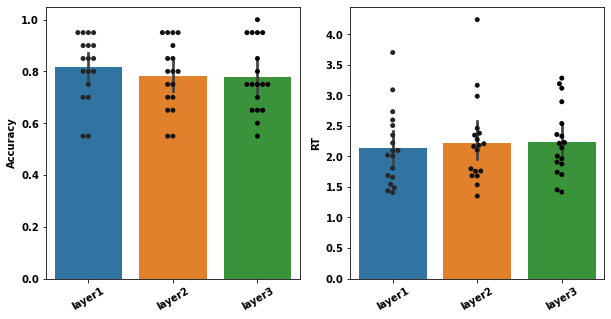

In [62]:
import seaborn as sns

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.barplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0])
sns.swarmplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')

sns.barplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1])
sns.swarmplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1],color='k')

axes[1].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[1].set_ylabel('RT')


Text(0, 0.5, 'RT')

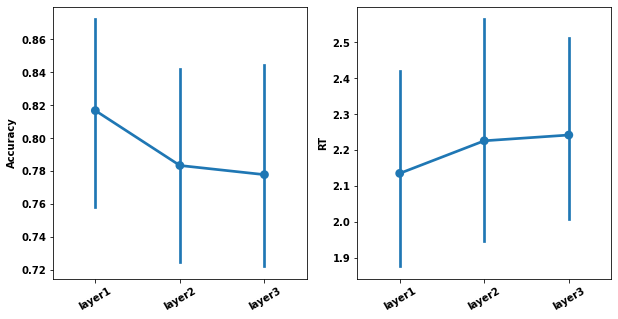

In [63]:
import seaborn as sns

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.pointplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0])
#sns.swarmplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')

sns.pointplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1])
#sns.swarmplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1],color='k')

axes[1].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[1].set_ylabel('RT')


In [64]:

final_participants_df['worker_ID'] = final_participants_df.index
rt_df = pd.melt(final_participants_df,id_vars=['worker_ID'],value_vars=['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt'],var_name='layer')

accuracy_df = pd.melt(final_participants_df,id_vars=['worker_ID'],value_vars=['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy'],var_name='layer')

C:\Users\d_abe\AppData\Local\Temp\ipykernel_27940\1535071135.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_participants_df['worker_ID'] = final_participants_df.index


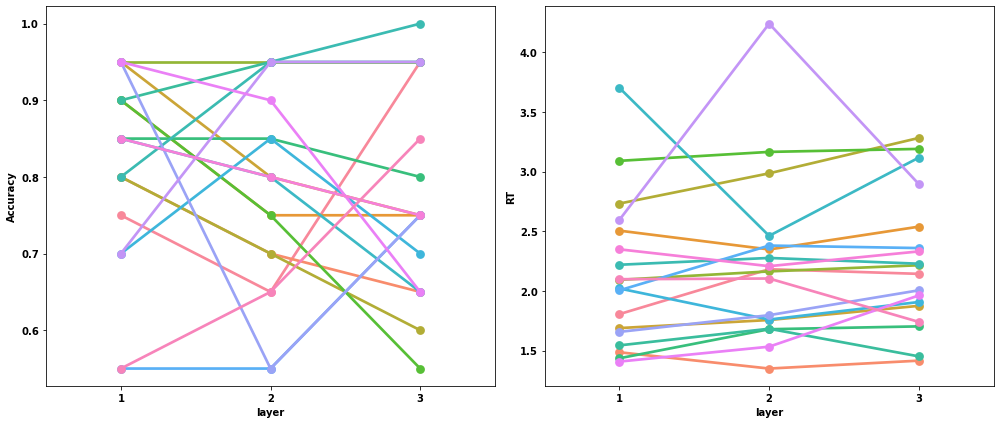

In [65]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(14,6),sharex=True,sharey=False)
#accuracy: 
G = sns.pointplot(data=accuracy_df,x='layer', y='value', hue='worker_ID', ax=axes[0])
plt.xticks([0,1,2],['1','2','3'])
axes[0].set_ylabel('Accuracy')
axes[0].get_legend().remove() 

#rt: 
sns.pointplot(data=rt_df,x='layer', y='value', hue='worker_ID', ax=axes[1])
plt.xticks([0,1,2],['1','2','3'])
plt.ylabel('RT')
axes[1].get_legend().remove() 
plt.tight_layout()

In [66]:
#this section loads the shelf dict in the state it is after finishing the testing session for this batch. 

import json
shelf_dict_after_test_name=PATH_TO_BATCH / 'shelf after session closed.txt' #define the name of the relevant shelf for this stage
with open(shelf_dict_after_test_name) as f:
    data = f.read()
shelf_dict = json.loads(data)
shelf_dict

{'A1PZIN8H1VI6SY': 999,
 'A2PI9FQWMWE8J3': 0,
 'ASC9DUCC64M3P': 1,
 'AX27MR7AMU52H': 2,
 'A37R0JYAB3QEX9': 3,
 'A2LMSIDVE4E4IO': 4,
 'A2AU7EEUOH7G0K': 999,
 'A33YJIL8ZY6XSB': 6,
 'A2GYZK79RQAH4I': 7,
 'APQW7NA9155CV': 8,
 'A1I98HJQ5MJV4T': 999,
 'A3E0IFFHYQPLFE': 9,
 'A3YG4NM3FQQQY': 10,
 'AIXO7JFFSBR5O': 11,
 'A50K26F2IS94U': 12,
 'AZBM9ZNBJC3VM': 999,
 'A3E85JBWPSBQEO': 13,
 'A306SRE7WZDAZS': 5,
 'A3EWR58W0SA885': 14,
 'AKSJ3C5O3V9RB': 15,
 'A1BRJXBMTURQNT': 16,
 'A1TM3LLCKLP5Y3': 17,
 'A209V2VHLLQ59W': 18,
 'AH7Z2M3KSQ4DW': 19,
 'A3DW6KSQPG6GVQ': 20,
 'A15UAR6NM0QVQN': 21,
 'AT80V0Q1U2LCI': 999,
 'A1C508BB6CF8VR': 23,
 'AMSVPV5BX5XFO': 22,
 'A2CE7Q3V4YEDOZ': 24,
 'A2CZ8O9PGNTC2L': 25,
 'AT80V0Q1U2LCI.': 26,
 'A1MD74JPL7E9PK': 27,
 'AAOYROFYRP1UM': 999,
 'A1AKL5YH9NLD2V': 28,
 'A3TBG0S2IEBVHU': 29,
 'A166BS4L4QUBR9': 30,
 'ANBCTN6HV7Y1M': 999,
 'A1M9D6GLMMA4OA': 31}

In [67]:
# upload qualifications csv
workers_df = pd.read_csv(PATH_TO_BATCH / 'Batch_workers.csv')
qualification_name_for_entire_experiment='UPDATE-completed memory rep'

In [68]:
#find all participants that exists in the shelf, and make sure they have a participantion code (so they wont be able to come back to this experiemnt)
all_shelf_workers_that_are_assigned_participantion=[]
for curr_key in shelf_dict.keys():
    if curr_key in workers_df['Worker ID'].values:
        workers_df.loc[workers_df['Worker ID']==curr_key,qualification_name_for_entire_experiment]=1
        all_shelf_workers_that_are_assigned_participantion.append(curr_key)

print(f'{len(all_shelf_workers_that_are_assigned_participantion)} were given a {qualification_name_for_entire_experiment}, names: {all_shelf_workers_that_are_assigned_participantion}')

#create a new shelf, that only contains the ids and numbers of valid participants (this is so we wont re-use thier custom trials order (csvs))
new_shelf_dict=dict()
for sub_id in final_participants_df.index: 
    sub_id = sub_id.split('_')[0]
    new_shelf_dict[sub_id]=shelf_dict[sub_id]
 

# append the final state of the last batch to the current batch for keeping all good participants 
previous_batch = 'batch ' + str(int(batch_name[-1]) - 1)
root_dirs = list(PATH_TO_BATCH.parent.iterdir())
target_dir = PATH_TO_BATCH.parent.parent / previous_batch
if target_dir in root_dirs:
    print(f'previous batch found:\n {target_dir} appending it to the shelf')
    path_final_state_shelf = target_dir / 'shelf final state.txt'
    with open(path_final_state_shelf) as f:
        data = f.read()
        shelf_dict = json.loads(data)
    
    new_shelf_dict = new_shelf_dict | shelf_dict

batch_workers_df_extended.to_csv(PATH_TO_BATCH/ path.Path(batch_name+'_workers_results_extended_with_disqualification.csv'))
workers_df.to_csv(PATH_TO_BATCH / path.Path(batch_name+'_workers_results_for_upload_after_encoding_and_test.csv'))
print('\n\ncopy the following dictionary content to the pavlovia dictionary, and to the "shelf final state.txt"\n')
json.dumps(new_shelf_dict)


31 were given a UPDATE-completed memory rep, names: ['A1PZIN8H1VI6SY', 'A2PI9FQWMWE8J3', 'ASC9DUCC64M3P', 'AX27MR7AMU52H', 'A37R0JYAB3QEX9', 'A2LMSIDVE4E4IO', 'A33YJIL8ZY6XSB', 'A2GYZK79RQAH4I', 'APQW7NA9155CV', 'A3E0IFFHYQPLFE', 'A3YG4NM3FQQQY', 'AIXO7JFFSBR5O', 'A50K26F2IS94U', 'A3E85JBWPSBQEO', 'A306SRE7WZDAZS', 'A1BRJXBMTURQNT', 'A1TM3LLCKLP5Y3', 'A209V2VHLLQ59W', 'AH7Z2M3KSQ4DW', 'A3DW6KSQPG6GVQ', 'A15UAR6NM0QVQN', 'AT80V0Q1U2LCI', 'A1C508BB6CF8VR', 'AMSVPV5BX5XFO', 'A2CZ8O9PGNTC2L', 'A1MD74JPL7E9PK', 'AAOYROFYRP1UM', 'A1AKL5YH9NLD2V', 'A3TBG0S2IEBVHU', 'A166BS4L4QUBR9', 'A1M9D6GLMMA4OA']


copy the following dictionary content to the pavlovia dictionary, and to the "shelf final state.txt"



'{"A37R0JYAB3QEX9": 3, "A3TBG0S2IEBVHU": 29, "A1BRJXBMTURQNT": 16, "A50K26F2IS94U": 12, "A33YJIL8ZY6XSB": 6, "A306SRE7WZDAZS": 5, "A1C508BB6CF8VR": 23, "A1AKL5YH9NLD2V": 28, "A3DW6KSQPG6GVQ": 20, "A1MD74JPL7E9PK": 27, "A2GYZK79RQAH4I": 7, "A3YG4NM3FQQQY": 10, "A2CZ8O9PGNTC2L": 25, "A2LMSIDVE4E4IO": 4, "AX27MR7AMU52H": 2, "A209V2VHLLQ59W": 18, "ASC9DUCC64M3P": 1, "A2PI9FQWMWE8J3": 0}'